In [86]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)

summary(effectiveCommentsData)

 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.00000   Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.00000   1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.00000   Median :0.0000      Median :0.0000           
 Mean   :0.07759   Mean   :0.3011      Mean   :0.2777           
 3rd Qu.:0.00000   3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :5.56068   Max.   :6.0426      Max.   :6.0039           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 10.44      Mean   :0.8902   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

In [87]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

[1] 19349


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.6931    Min.   :0.6931      Min.   :0.6931           
 1st Qu.:0.6931    1st Qu.:1.0986      1st Qu.:1.0986           
 Median :1.0986    Median :1.7918      Median :1.6094           
 Mean   :1.3103    Mean   :1.9356      Mean   :1.7920           
 3rd Qu.:1.6094    3rd Qu.:2.5649      3rd Qu.:2.3979           
 Max.   :5.5607    Max.   :6.0426      Max.   :5.8406           
                                                                
 ShareReviewComments GeneralComments GeneralCommentsDiscussingBuild
 Min.   :  1.19      Min.   :0.000   Min.   :0                     
 1st Qu.: 36.71      1st Qu.:1.099   1st Qu.:0                     
 Median : 60.00      Median :1.609   Median :0                     
 Mean   : 58.44      Mean   :1.623   Mean   :0                     
 3rd Qu.: 80.00      3rd Qu.:2.197   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.136   Max.   :0                     
    

# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [88]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(hasEffectiveComments)),]

combined <- rbind(sampledZerosdf, hasEffectiveComments)

hurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModel)
r.squaredGLMM(hurdleModel)
vif(hurdleModel)
anova(hurdleModel)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + LanguageType + IsAfter, family = "binomial", 
    data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.7958  -0.2077  -0.0040   0.2435   2.7072  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.74492    0.22029 -21.539  < 2e-16 ***
Additions                     -0.01246    0.01702  -0.732 0.464101    
Deletions                     -0.18171    0.01652 -10.996  < 2e-16 ***
IsMergedTrue                   0.58702    0.05147  11.405  < 2e-16 ***
Commits                       -0.68838    0.05410 -12.724  < 2e-16 ***
Assignees                      0.27661    0.09876   2.801 0.005

R2m      R2c 
0.862437 0.862437

,GVIF,Df,GVIF^(1/(2*Df))
Additions,3.160224,1,1.777702
Deletions,2.510285,1,1.584388
IsMerged,1.130696,1,1.063342
Commits,2.467095,1,1.570699
Assignees,1.025993,1,1.012913
ChangedFiles,3.492311,1,1.868772
NumOfUniqueUsers,2.554137,1,1.598167
PRsOpened,2.783331,1,1.668332
TotalBuilds,3.195875,1,1.787701
NewContributor,1.728829,1,1.314850


,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,38697,53646.82
Additions,1,4.257262e+03,38696,49389.56
Deletions,1,2.973734e+02,38695,49092.18
IsMerged,1,3.807491e+01,38694,49054.11
Commits,1,8.848351e+03,38693,40205.76
Assignees,1,1.954070e+02,38692,40010.35
ChangedFiles,1,2.248631e+02,38691,39785.49
NumOfUniqueUsers,1,8.336719e+03,38690,31448.77
PRsOpened,1,1.808354e+00,38689,31446.96
TotalBuilds,1,4.610147e+02,38688,30985.95


In [89]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [90]:
baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.39529 -0.22635  0.04219  0.25892  1.93464 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.288529   0.035083   8.224  < 2e-16 ***
Additions                      0.024047   0.002518   9.549  < 2e-16 ***
Deletions                     -0.058102   0.002272 -25.571  < 2e-16 ***
IsMergedTrue                   0.016429   0.008181   2.008   0.0446 *  
Assignees                     -0.029655   0.013705  -2.164   0.0305 *  
ChangedFiles                   0.010685   0.005574   1.917   0.0553 .  
NumOfUniqueUsers              -0.060049   0.012319  -4.874 1.10e-06 ***
PRsOpened                     -0.012895   0.002748  -4.692 2.72e-06 ***
TotalBuilds                    0.071588   0.005574  12.844  < 2e-16 ***
NewContributorTrue            -0.012864   0.011827  -1.088   0.2767    
PrOpenedDaysAfterProjectStart  0.005226   0.004

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [91]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.38871 -0.22429  0.04301  0.25913  1.94040 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.289052   0.035076   8.241  < 2e-16 ***
Additions                      0.023592   0.002517   9.372  < 2e-16 ***
Deletions                     -0.057675   0.002271 -25.391  < 2e-16 ***
IsMergedTrue                   0.015186   0.008190   1.854  0.06373 .  
Assignees                     -0.031341   0.013699  -2.288  0.02216 *  
ChangedFiles                   0.012980   0.005587   2.323  0.02018 *  
NumOfUniqueUsers              -0.063020   0.012319  -5.116 3.16e-07 ***
PRsOpened                     -0.011806   0.002759  -4.279 1.88e-05 ***
TotalBuilds                    0.070476   0.005587  12.614  < 2e-16 ***
NewContributorTrue            -0.012354   0.011817  -1.045  0.29587    
PrOpenedDaysAfterProjectStart  0.004621   0.004

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.37765 -0.23607  0.04689  0.26601  1.95908 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.316050   0.038649   8.177 3.11e-16 ***
Additions                       0.024188   0.002823   8.569  < 2e-16 ***
Deletions                      -0.059429   0.002518 -23.605  < 2e-16 ***
IsMergedTrue                    0.008288   0.008958   0.925 0.354917    
Assignees                      -0.044767   0.015272  -2.931 0.003379 ** 
ChangedFiles                    0.014901   0.006213   2.398 0.016484 *  
NumOfUniqueUsers               -0.058437   0.013747  -4.251 2.14e-05 ***
PRsOpened                      -0.011877   0.003106  -3.824 0.000132 ***
TotalBuilds                     0.074618   0.006188  12.058  < 2e-16 ***
NewContributorTrue             -0.017354   0.013179  -1.317 0.187914    
PrOpenedDaysAfterProjectStart   0.00

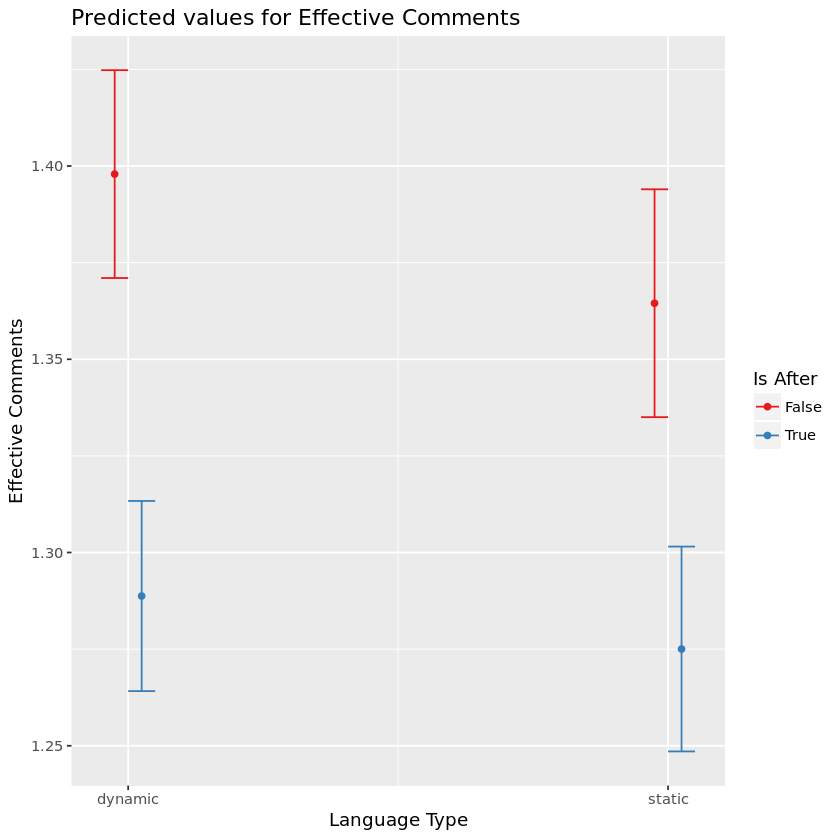

In [92]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('LanguageType', 'IsAfter'))

# Dynamic languages

In [93]:
dynModel <- executeLmOnData(
           EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'dynamic'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.11463 -0.22981  0.04644  0.26594  1.69788 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.156000   0.049882   3.127 0.001769 ** 
Additions                      0.020628   0.003554   5.804 6.66e-09 ***
Deletions                     -0.062102   0.003248 -19.122  < 2e-16 ***
IsMergedTrue                   0.012076   0.011017   1.096 0.273017    
Commits                        0.059049   0.007696   7.673 1.84e-14 ***
Assignees                     -0.026388   0.019063  -1.384 0.166320    
ChangedFiles                   0.010414   0.008290   1.256 0.209067    
NumOfUniqueUsers              -0.046921   0.017839  -2.630 0.008545 ** 
PRsOpened                     -0.009027   0.004063  -2.222 0.026318 *  
TotalBuilds                    0.036965   0.008979   4.117 3.87e-05 ***
NewContributorTrue            -0.011443   0.015

# Static languages

In [94]:
staticModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'static'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.30776 -0.25042  0.04307  0.26654  1.96999 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.309567   0.065506   4.726 2.34e-06 ***
Additions                      0.025831   0.004619   5.592 2.34e-08 ***
Deletions                     -0.055547   0.003956 -14.041  < 2e-16 ***
IsMergedTrue                   0.014668   0.015321   0.957   0.3384    
Commits                        0.069771   0.008699   8.020 1.25e-15 ***
Assignees                     -0.062259   0.025403  -2.451   0.0143 *  
ChangedFiles                  -0.009037   0.009776  -0.924   0.3553    
NumOfUniqueUsers              -0.053491   0.021529  -2.485   0.0130 *  
PRsOpened                     -0.012031   0.004864  -2.473   0.0134 *  
TotalBuilds                    0.053773   0.010350   5.195 2.11e-07 ***
NewContributorTrue            -0.024568   0.023